<a href="https://colab.research.google.com/github/ilman79/Machine-Learning/blob/main/Development_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Akses untuk melihat sumber data dari website kaggle : [dataset](https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification?resource=download)

In [1]:
#import data set
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gifariilman","key":"5c2fca0d1e6e17444d289ca2575e590e"}'}

In [3]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle --version

Kaggle API 1.5.13


In [5]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

100% 4.15G/4.16G [00:40<00:00, 120MB/s]
100% 4.16G/4.16G [00:40<00:00, 111MB/s]


In [6]:
!kaggle datasets download -d valentynsichkar/traffic-signs-dataset-in-yolo-format

 96% 240M/250M [00:01<00:00, 215MB/s]
100% 250M/250M [00:01<00:00, 171MB/s]


In [7]:
!unzip /content/traffic-signs-dataset-in-yolo-format.zip -d /content/dataset-yolo

Archive:  /content/traffic-signs-dataset-in-yolo-format.zip
  inflating: /content/dataset-yolo/classes.names  
  inflating: /content/dataset-yolo/getting-full-path.py  
  inflating: /content/dataset-yolo/test.txt  
  inflating: /content/dataset-yolo/traffic-sign-to-test.mp4  
  inflating: /content/dataset-yolo/train.txt  
  inflating: /content/dataset-yolo/ts/ts/00000.jpg  
  inflating: /content/dataset-yolo/ts/ts/00000.txt  
  inflating: /content/dataset-yolo/ts/ts/00001.jpg  
  inflating: /content/dataset-yolo/ts/ts/00001.txt  
  inflating: /content/dataset-yolo/ts/ts/00002.jpg  
  inflating: /content/dataset-yolo/ts/ts/00002.txt  
  inflating: /content/dataset-yolo/ts/ts/00003.jpg  
  inflating: /content/dataset-yolo/ts/ts/00003.txt  
  inflating: /content/dataset-yolo/ts/ts/00004.jpg  
  inflating: /content/dataset-yolo/ts/ts/00004.txt  
  inflating: /content/dataset-yolo/ts/ts/00005.jpg  
  inflating: /content/dataset-yolo/ts/ts/00005.txt  
  inflating: /content/dataset-yolo/ts/ts

In [8]:
!unzip /content/traffic-signs-preprocessed.zip -d /content/sample_data

Archive:  /content/traffic-signs-preprocessed.zip
  inflating: /content/sample_data/data0.pickle  
  inflating: /content/sample_data/data1.pickle  
  inflating: /content/sample_data/data2.pickle  
  inflating: /content/sample_data/data3.pickle  
  inflating: /content/sample_data/data4.pickle  
  inflating: /content/sample_data/data5.pickle  
  inflating: /content/sample_data/data6.pickle  
  inflating: /content/sample_data/data7.pickle  
  inflating: /content/sample_data/data8.pickle  
  inflating: /content/sample_data/datasets_preparing.py  
  inflating: /content/sample_data/label_names.csv  
  inflating: /content/sample_data/labels.pickle  
  inflating: /content/sample_data/mean_image_gray.pickle  
  inflating: /content/sample_data/mean_image_rgb.pickle  
  inflating: /content/sample_data/std_gray.pickle  
  inflating: /content/sample_data/std_rgb.pickle  
  inflating: /content/sample_data/test.pickle  
  inflating: /content/sample_data/train.pickle  
  inflating: /content/sample_dat

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
import os

from keras.models import load_model

In [10]:
# Reading csv file with labels' names
# Loading two columns [0, 1] into Pandas dataFrame
labels = pd.read_csv('/content/sample_data/label_names.csv')

# Check point
# Showing first 5 rows from the dataFrame
print(labels.head())
print()

# To locate by class number use one of the following
# ***.iloc[0][1] - returns element on the 0 column and 1 row
print(labels.iloc[0][1])  # Speed limit (20km/h)
# ***['SignName'][1] - returns element on the column with name 'SignName' and 1 row
print(labels['SignName'][1]) # Speed limit (30km/h)

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (30km/h)


In [11]:
# arrays to store file names
imgs = []
xmls = []

# setup directory names
train_path = "/content/dataset/images/train"
val_path = "/content/dataset/images/val"

# images are initially stored here in kaggle
crs_path = "/content/dataset-yolo/ts/ts"

# deciding the ration in which the dataset needs to be divided
train_ratio = 0.8
val_ratio = 0.2

# total count of imgs
total_img_count = len(os.listdir(crs_path))/2

# sorting count of imgs
for (dirname, dirs, files) in os.walk(crs_path):
    for filename in files:
        if filename.endswith(".txt"):
            xmls.append(filename)
        else:
            imgs.append(filename)

# counting range for cycles
count_for_train = int(len(imgs) * train_ratio)
count_for_val = int(len(imgs) * val_ratio)
print("Training images are : ",count_for_train)
print("Validation images are : ",count_for_val)

Training images are :  592
Validation images are :  148


In [12]:
len(imgs)

741

In [13]:
import torch
from IPython.display import Image
import shutil
from random import choice

In [14]:
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 2.0.1+cu118 CPU


In [15]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.0/107.7 GB disk)


In [17]:
NOTES_PATH = "/content/dataset/dataset.yaml"

In [23]:
# creation of directories in kaggle/working path
train_image_path = "/content/dataset/images/train"
train_label_path = "/content/dataset/labels/train"
val_image_path = "/content/dataset/images/val"
val_label_path = "/content/dataset/labels/val"

if not os.path.isdir(train_image_path):
    os.makedirs(train_image_path)
if not os.path.isdir(train_label_path):
    os.makedirs(train_label_path)
if not os.path.isdir(val_image_path):
    os.makedirs(val_image_path)
if not os.path.isdir(val_label_path):
    os.makedirs(val_label_path)

In [24]:
#For training images
# Copying the images from input directory to working directory -> kaggle/working/dataset/images/train
for x in range(count_for_train):
    file_jpg = choice(imgs)
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(train_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(train_label_path,file_xml))
    
    imgs.remove(file_jpg)
    xmls.remove(file_xml)

In [25]:
# For test images
for x in range(count_for_val):
    file_jpg = choice(imgs)
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(val_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(val_label_path,file_xml))
    
    imgs.remove(file_jpg)
    xmls.remove(file_xml)

In [26]:
print("images length - ",len(imgs))
print(imgs,xmls)
for x in imgs:
    file_jpg = x
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(val_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(val_label_path,file_xml))
# shutil.copytree(crs_path,val_path)

images length -  1
['00038.jpg'] ['00038.txt']


In [27]:
import numpy as np
import pandas as pd
import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
import pickle
from keras.models import load_model

#Testing menggunakan yoloV5

In [29]:
with open(r'/content/dataset/dataset.yaml', 'r') as file:
    lines = file.readlines()
    print(lines)

['path: /content/dataset-yolo/ts/ts\n', 'train: /content/dataset/images/train\n', 'val: /content/dataset/images/val\n', 'nc: 4\n', "names: ['prohibitory', 'danger', 'mandatory', 'other']"]


In [31]:
!python train.py --img 415 --batch 16 --epochs 30 --data /content/dataset/dataset.yaml --weights yolov5s.pt --cache --workers 2

train: weights=yolov5s.pt, cfg=, data=/content/dataset/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=415, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees

In [44]:
!python detect.py --source /content/dataset-yolo/traffic-sign-to-test.mp4 --weights /content/yolov5/runs/train/exp2/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], source=/content/dataset-yolo/traffic-sign-to-test.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/56) /content/dataset-yolo/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 262.9ms
video 1/1 (2/56) /content/dataset-yolo/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 270.3ms
video 1/1 (3/56) /content/dataset-yolo/traffic-sign-to-test.mp4: 384x640 2 prohibitorys, 258.6ms
video 1/1 (4/56) /content/dataset-y

In [45]:
!ls ./runs/detect/exp4

traffic-sign-to-test.mp4


In [46]:
from IPython.display import Image
from random import choice
Image(filename='/content/dataset-yolo/traffic-sign-to-test.mp4', width=416)

ValueError: ignored

In [48]:
from google.colab import drive
drive.mount('/content/yolov5/runs/detect/exp4/traffic-sign-to-test.mp4')

MessageError: ignored

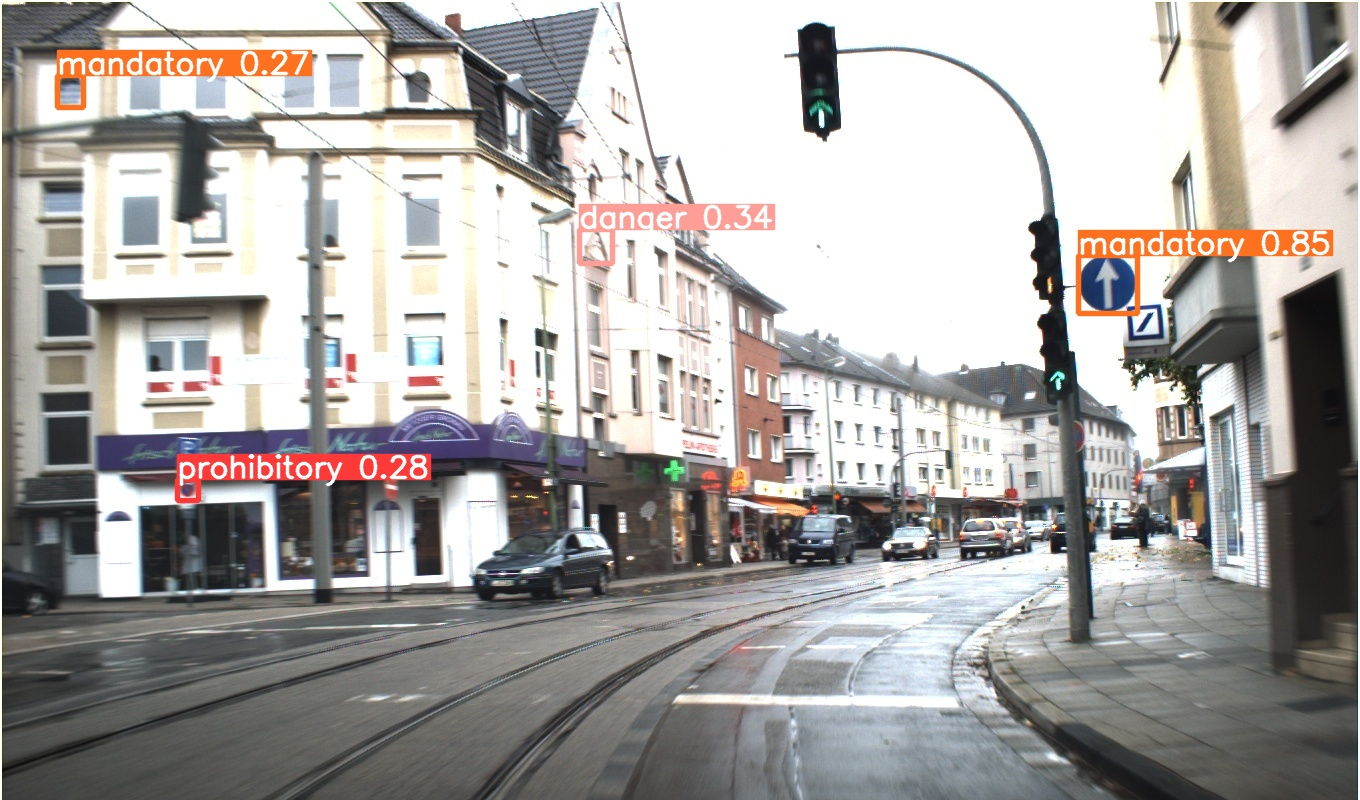

In [43]:
Image(filename='/content/yolov5/runs/detect/exp3/00116.jpg', width=416)